## CTslice dataset


### (1) Getting imports and definitions
#### (libraries and functions)

In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

""" 
SS GP algorithm functions
"""

import os
os.chdir('C:/Users/hughw/Documents/MSC project/GP algorithms/Master function files')
from GP_funcs_ZTMFSS import kernel_funcs
from GP_funcs_ZTMFSS import model_funcs
from GP_funcs_ZTMFSS import draw_GP
from GP_funcs_ZTMFSS import fit
from GP_funcs_ZTMFSS import diagnostics
from GP_funcs_ZTMFSS import simulations
from functools import partial
os.chdir('C:/Users/hughw/Documents/MSC project/Real data')

"""
Importing in rpy2
"""

os.environ['R_USER'] = 'D:\Anaconda3\Lib\site-packages\rpy2'
import rpy2
print(rpy2.__version__)
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')
base.R_home()
# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# Function definitions for comparators - MAKE IT SO THEY ALWAYS JUST RETURN PREDICTIONS AND CLASSIFICATIONS
"""
Importing in requirements for SVGP Pytorch
"""
import tqdm
import math
import torch
import gpytorch

"""
Defining procedure to run SVGP
"""

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader

def SVGP_train(y, X, lengthscale_init = 10, num_inducing=100, epochs=100, batch_size=100, learn_rate_variational = 0.1, learn_rate_hyper = 0.01, tol = 1e-4,seed=0, min_epochs = 100
              , alpha = 0.05, print_=False):
    
    # setting dimensions
    ntrain,ntest, p = len(y), len(X), len(X.T)
    
    # loading in data
    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

    # Creating model
    class GPModel(ApproximateGP):
        def __init__(self, inducing_points):
            variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
            variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
            super(GPModel, self).__init__(variational_strategy)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel=gpytorch.kernels.RBFKernel(ard_num_dims = p))

            # Initialize lengthscale
            if np.any(lengthscale_init):
                self.covar_module.base_kernel.lengthscale = np.ones(p)*lengthscale_init

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    np.random.seed(seed)
    inducing_points = X[np.random.choice(ntrain,num_inducing,False), :]
    model = GPModel(inducing_points=inducing_points)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

        num_epochs = epochs

    # Setting up model training
    t = time.time()
    torch.manual_seed(seed)
    model.train()
    likelihood.train()
    
    variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=train_y.size(0), lr=learn_rate_variational)

    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr=learn_rate_hyper)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
    
    # Setting up convergence criteria
    epochs_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
    i = 0
    param_diff=1
    loss_diff=1
    param = 1/model.covar_module.base_kernel.lengthscale
    
    # Training model
    while (i < epochs and loss_diff>0) or i<min_epochs:
        
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            
            ### Perform NGD step to optimize variational parameters
            variational_ngd_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            variational_ngd_optimizer.step()

            ### Perform Adam step to optimize hyperparameters
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            hyperparameter_optimizer.step()
        
        # Update convergence criteria
        i+=1
        param_old = param
        param = 1/model.covar_module.base_kernel.lengthscale
        param_diff = np.mean(np.abs((param-param_old).detach().numpy()))
        if i==1:
            loss_new = loss.item()
        else:
            loss_old = loss_new
            loss_new = loss.item()*alpha+(1-alpha)*loss_old
            loss_diff = loss_old - loss_new
        
        numprint = min(10,p)
        if print_:
            print(np.sort(model.covar_module.base_kernel.lengthscale.detach().numpy())[0][:numprint])
            print(loss_new, param_diff)
    print("Runtime is ", time.time()-t)
    
    return model, loss, likelihood

def SVGP_test(model,likelihood, ytest, Xtest, batch_size=100):

    test_dataset = TensorDataset(Xtest, ytest)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

    # Getting model evaluations
    model.eval()
    likelihood.eval()
    means = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch)
            means = torch.cat([means, preds.mean.cpu()])
    means = means[1:]
    
    print('Test MSE: {}'.format(torch.mean(torch.abs(means - ytest.cpu())**2)))
    
    return means

"""
Defining procedure to run SGP
"""

from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

def SGP_train(y, X, lengthscale_init = 10, num_inducing=100, iterations=100, learn_rate = 0.1, tol = 1e-4, seed=0, min_iterations = 100, alpha = 0.05, print_=False):
    
    # setting dimensions
    ntrain,ntest, p = len(y), len(X), len(X.T)

    # Creating model
    
    class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, inducing_points):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = ConstantMean()
            self.base_covar_module = ScaleKernel(RBFKernel(ard_num_dims = p))
            self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=inducing_points, likelihood=likelihood)

            # Initialize lengthscale
            if np.any(lengthscale_init):
                self.base_covar_module.base_kernel.lengthscale = np.ones(p)*lengthscale_init

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return MultivariateNormal(mean_x, covar_x)

        np.random.seed(seed)
    
    inducing_points = X[np.random.choice(ntrain,num_inducing,False), :]
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood, inducing_points)

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    # Setting up model training
    t = time.time()
    torch.manual_seed(seed) 
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Setting up convergence criteria
    i = 0
    param_diff=1
    loss_diff=1
    param = 1/model.base_covar_module.base_kernel.lengthscale
    
    # Training model
    while (i < iterations and loss_diff>0) or i<min_iterations:
        
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        
        # Update convergence criteria
        i+=1
        param_old = param
        param = 1/model.base_covar_module.base_kernel.lengthscale
        param_diff = np.mean(np.abs((param-param_old).detach().numpy()))
        if i==1:
            loss_new = loss.item()
        else:
            loss_old = loss_new
            loss_new = loss.item()*alpha+(1-alpha)*loss_old
            loss_diff = loss_old - loss_new
        
        numprint = min(10,p)
        if not i % 1:
            if print_:
                print(np.sort(model.base_covar_module.base_kernel.lengthscale.detach().numpy())[0][:numprint])
                print(loss_new, param_diff)
                print('Iter %d - Loss: %.3f' % (i + 1, loss.item()))
    print("Runtime is ", time.time()-t)
    
    return model, loss, likelihood

def SGP_test(model,likelihood, ytest, Xtest):
    
    # Getting model evaluations
    model.eval()
    likelihood.eval()
    with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
        preds = model(Xtest)
    
    print('Test MSE: {}'.format(torch.mean(torch.abs(preds.mean - ytest.cpu())**2)))
    
    return preds.mean

3.4.5


### (2) Getting data 
#### (takes in a file and outputs cleaned data y, X)

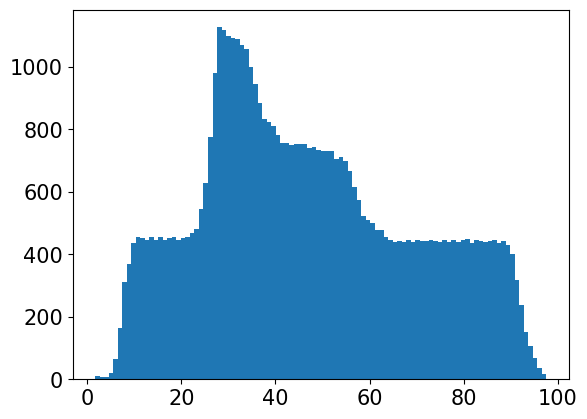

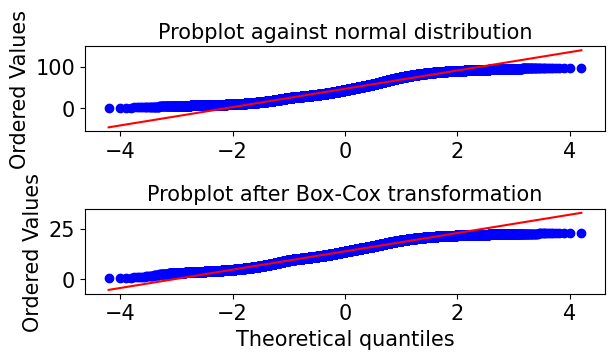

dimensions are :  (53500, 381)


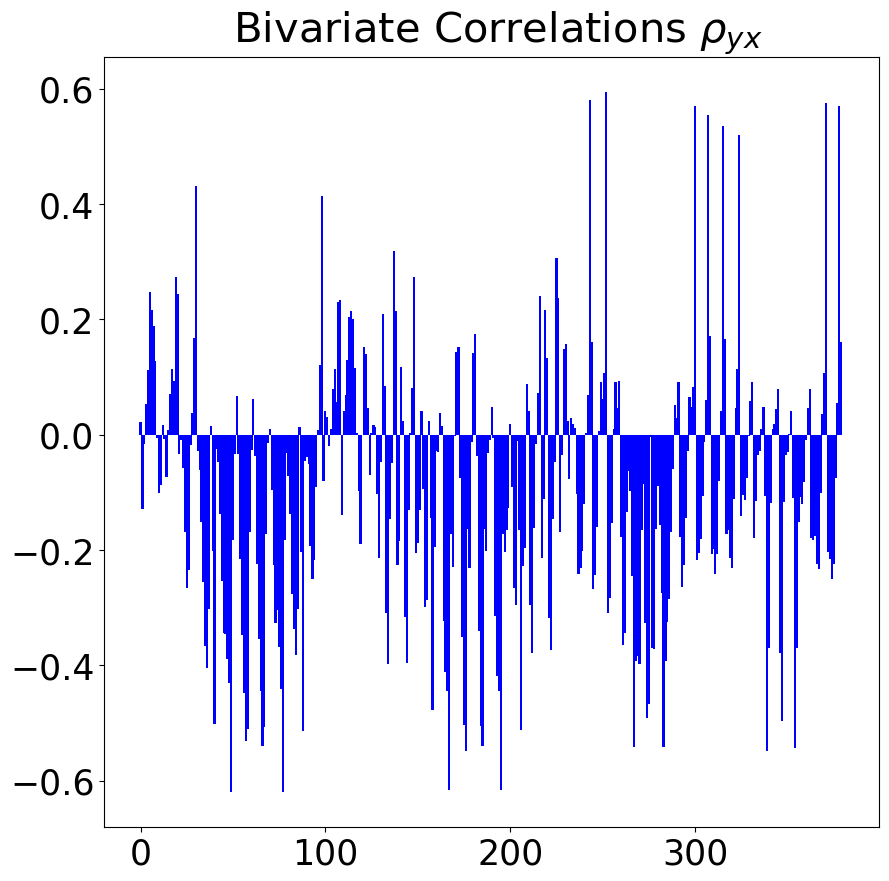

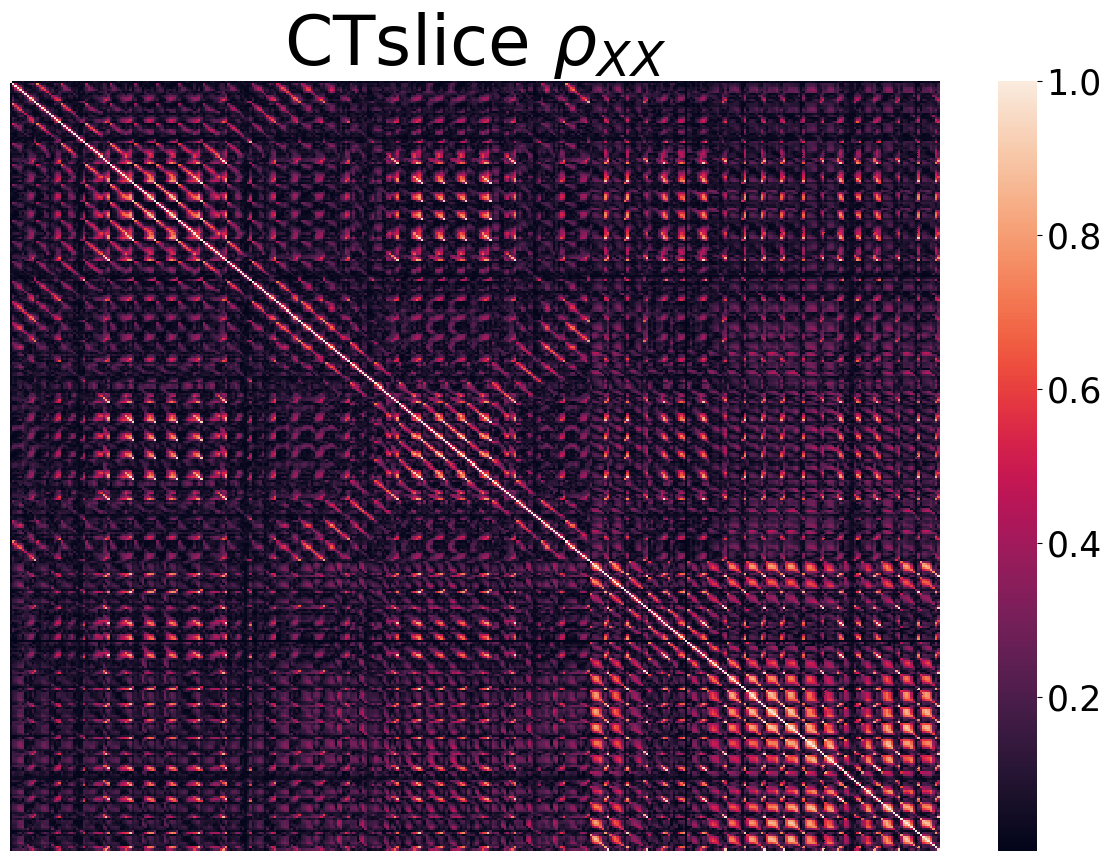

In [116]:
# Inputting raw data
from matplotlib import rcParams, rc_file_defaults
rc_file_defaults()
plt.rc('axes',edgecolor='black')
font = {'family' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams.update({'text.color' : "black",
                      'xtick.color' : "black",
                      'ytick.color' : "black",
                     'axes.labelcolor' : "black"})

df = pd. read_csv ("slice_localization_data.csv") 
data = np.array(df)

# Box cox transformations to dependent
y = data[:,len(data.T)-1].astype(float)
plt.hist(y, bins = 100)

fig = plt.figure()
ax1 = fig.add_subplot(311)
prob = stats.probplot(y, dist=stats.norm, plot=ax1)
ax1.set_xlabel('', fontsize = 15)
ax1.set_title('Probplot against normal distribution', size = 15)

ax2 = fig.add_subplot(312)
yt, _ = stats.boxcox(y+1e-10)
prob = stats.probplot(yt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation', size = 15)
plt.tight_layout()
plt.show()

D = data[:,data.var(0)>0].astype(float)
print("dimensions are : ", np.shape(D))

# Getting correlations
font = {'family' : 'normal',
        'size'   : 25}
plt.rc('font', **font)
n,p = np.shape(D)
d = p-1
corrxy = np.zeros(p)
for i in range(len(D.T)-1):
     corrxy[i]=np.corrcoef(D[:,i],yt)[0,1]
fig,axs = plt.subplots(figsize = (10,10))
fig.set_facecolor('white')
axs.set_facecolor('white')
plt.bar(range(p),height = corrxy, color = "blue", width=1.2)
plt.title(r" Bivariate Correlations $\rho_{yx}$")
plt.show()
fig.savefig("CorryX_CTslice")
fig,axs = plt.subplots(figsize = (15,10))
sns.heatmap(np.abs(np.corrcoef(D[:,:len(D.T)-1].T)), label = "Correlation matrix", yticklabels= False, xticklabels = False)
plt.title(r"CTslice $\rho_{XX}$", fontsize = 50, color = "black")
plt.show()
fig.savefig("CorrX_CTslice")

# get y, X
y = yt
X = D[:,:len(D.T)-1]

### (3) Setting up experiment dimensions 
#### (determine random train:test splits and set up storage objects)

In [3]:
# Train:test splitting settings
n_replications = 15
ntrain = int(0.8*n)
ntest = n - ntrain
nmodel = 3

# Model settings
minibatch = 256
nns=256
learn_rate = 0.0025
sampling_strat = "nn"
min_VBEM_iter = 3
max_VBEM_iter = 5
gp_iters = 200
VBEM_tol = 0.1/d
kern = kernel_funcs.gaussian
grad_kern = kernel_funcs.grad_gaussian
post_var = False
post_cov = False
train_largest = True
folds = 2
MC=1000
learn_rate_mult = 1
spike = 1e+4
final_ELBO_sample = int(n/1000)
reg = 0.01
v_l0, v_l1, a,b = 1e+4,1e-4,1e-3,1e-3
ELBO_sample=1000
temp=1
Xscales = 2**np.linspace(np.log2(100),-np.log2(100),11)

# Storage objects
MSE = np.zeros((n_replications, nmodel))
Runtime = np.zeros((n_replications, nmodel))
L = np.zeros((n_replications, nmodel, d))
Lambda = np.zeros((n_replications, nmodel, d))

# Model choices
linear_models = False
MSE_hyperopt = True
SGPs = True
SSVGPs = True
predict_selected = True

### (4) Iterating over train:test splits

In [4]:
"""
Runs for SVGP/SGP only
"""
for i in range(n_replications): # use just three runs as takes too long to do more!
    np.random.seed(i)
    
    shuffled_indexes = np.random.choice(n,n,False)
    y_shuffle = y[shuffled_indexes]
    X_shuffle = X[shuffled_indexes]
    
    if np.min(X_shuffle[:ntrain].var(0))>0:
    
    # Get current train:test split
        ytrain = ((y_shuffle[:ntrain]-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(ntrain,1)
        ytest = ((y_shuffle[ntrain:]-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(ntest,1)

        Xtrain = (X_shuffle[:ntrain] - X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**.5
        Xtest = (X_shuffle[ntrain:] - X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**.5

    # Run all SS-GP algorithms,  get predictions and store performance
        m=3 
        
        """
        SGD GP
        """
        m += 1
        t= time.time()

        # Running algorithm
        results = fit.VB_EM_GP_SS(ytrain, Xtrain, l0 = 0.01, reg = 0.01, learn_rate = 0.01, sampling_strat = sampling_strat, v0=1e+4, learn_spike = False, 
                              min_VBEM_iter=1,max_VBEM_iter = 1, init_GP_iter = 200, optimisation = "adam",
                              subsample = minibatch, iter_remove = False, kern=kern, grad_kern = grad_kern, print_VBEM=False, seed=i)

        # Getting predictions
        fpost_mean, fpost_var, ypost_mean, ypost_var = diagnostics.get_pred_posterior_GP_NN(ytrain,Xtrain,Xtest,results[0][0],results[1],results[2],reg=0.01,kern=kern,grad_kern =grad_kern,
                                                                                NN=minibatch, select = results[3]>0.01,fraction = 1, grad_steps = 0, learn_rate = 0.1, tol = 1e-5, print_grad=False,pred_selected = False, latents = False)
        MSE[i,m] = simulations.MSE_pc(ypost_mean,ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = results[0][0]
        Lambda[i,m,:] = results[3]
        print("MSE is : ", MSE[i,m])


        """
        SGP
        """
        m += 1
        Ys = ((y_shuffle-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(n,1)
        Xs = ((X_shuffle-X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**0.5).reshape(n,d)
        Xtorch = torch.from_numpy(Xs).float()
        Ytorch = torch.from_numpy(Ys.reshape(ntrain+ntest,)).float()


        train_x = Xtorch[:ntrain, :]
        train_y = Ytorch[:ntrain]
        test_x = Xtorch[ntrain:, :]
        test_y = Ytorch[ntrain:]

        t = time.time()
        model,loss,likelihood = SGP_train(train_y, train_x, lengthscale_init = [], num_inducing=512, iterations=100, learn_rate = 0.1, 
                                    seed = 0, min_iterations=100, alpha = 0.01)
        preds = SVGP_test(model,likelihood,test_y, test_x, batch_size=512)
        Runtime[i,m] = time.time()-t
        MSE[i,m] = simulations.MSE_pc(np.array(preds),np.array(test_y))
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])
        #L[i,m,:] = 1/model.covar_module.base_kernel.lengthscale.detach().numpy()[0]

        """
        SVGP
        """
        m += 1
        model,loss,likelihood = SVGP_train(train_y, train_x, lengthscale_init = [], num_inducing=1024, epochs=100, batch_size=1024, learn_rate_variational = 0.01, 
                                           learn_rate_hyper = 0.01, tol = 1e-3, seed = 0, min_epochs = 100, alpha = 0.01)

        preds = SVGP_test(model,likelihood,test_y, test_x, batch_size=1024)
        Runtime[i,m] = time.time()-t
        MSE[i,m] = simulations.MSE_pc(np.array(preds),np.array(test_y))
        L[i,m,:] = 1/model.covar_module.base_kernel.lengthscale.detach().numpy()[0]
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])

        print("MSE mean is : ", MSE[:i+1].mean(0))
        print("Runtime mean is : ", Runtime[:i+1].mean(0))

KeyboardInterrupt: 

In [42]:
"""
BMA over different minibatch sizes
"""

for i in range(n_replications): 
    np.random.seed(i)
    
    shuffled_indexes = np.random.choice(n,n,False)
    y_shuffle = y[shuffled_indexes]
    X_shuffle = X[shuffled_indexes]
    
    if np.min(X_shuffle[:ntrain].var(0))>0:
    
    # Get current train:test split
        ytrain = ((y_shuffle[:ntrain]-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(ntrain,1)
        ytest = ((y_shuffle[ntrain:]-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(ntest,1)

        Xtrain = (X_shuffle[:ntrain] - X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**.5
        Xtest = (X_shuffle[ntrain:] - X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**.5

    # Run all SS-GP algorithms,  get predictions and store performance


        """
        Initialising model weight vector
        """
        weights = np.zeros(10)
        
        """
        BMA over X_scale (256)
        """
        m =0
        t = time.time()

        # Running algorithm
        testing_algorithm = partial(diagnostics.get_pred_posterior_GP_NN,reg = 0.01 ,kern = kern, grad_kern = grad_kern, latents = False, pred_selected = True, post_var = False, NN=nns, print_=True)
        hyper_vals = [1e+4*Xscales,1e-4*Xscales]
        hyper_arg = ["v0","v1"]
        best_pair, selections, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[0, spike, i,        True,          False,      learn_rate,    int(minibatch),    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/d, learn_rate_mult])

        t1 = time.time()

        # MSE WEIGHTING
        
        log_predictives = np.zeros(len(Results))
        for j in np.where(selections!=0)[0]:
            log_predictives[j] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[j],0.01,kern,NN=64, fraction=n**-0.5,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
            print(j)
        log_predictives[np.where(selections==0)[0]]=np.min(log_predictives)-1000
        
        train_time = time.time()-t

        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        Lmbda = np.zeros((len(Results), d))
        Ls = np.zeros((len(Results), d))
        for j in range(len(Results)):
            Lmbda[j] = Results[j][3]
            Ls[j] = np.abs(Results[j][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights

        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = l
        Lambda[i,m,:] = PIP
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])
        
        """
        BMA over X_scale (128)
        """
        m += 1 
        t = time.time()

        # Running algorithm
        hyper_vals = [1e+4*Xscales,1e-4*Xscales]
        hyper_arg = ["v0","v1"]
        best_pair, selections, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[0, spike, i,        True,          False,      learn_rate*2,    int(minibatch/2),    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/d, learn_rate_mult])

        t1 = time.time()

        log_predictives = np.zeros(len(Results))
        for j in np.where(selections!=0)[0]:
            log_predictives[j] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[j],0.01,kern,NN=64, fraction=n**-0.5,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
            print(j)
        log_predictives[np.where(selections==0)[0]]=np.min(log_predictives)-1000 
        
        train_time = time.time()-t

        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        Lmbda = np.zeros((len(Results), d))
        Ls = np.zeros((len(Results), d))
        for j in range(len(Results)):
            Lmbda[j] = Results[j][3]
            Ls[j] = np.abs(Results[j][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights

        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = l
        Lambda[i,m,:] = PIP
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])
        
        """
        BMA over X_scale (64)
        """
        m +=1
        t = time.time()

        # Running algorithm
        hyper_vals = [1e+4*Xscales,1e-4*Xscales]
        hyper_arg = ["v0","v1"]
        best_pair, selections, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[0, spike, i,        True,          False,      learn_rate*4,    int(minibatch/4),    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/d, learn_rate_mult])

        t1 = time.time()

        log_predictives = np.zeros(len(Results))
        for j in np.where(selections!=0)[0]:
            log_predictives[j] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[j],0.01,kern,NN=64, fraction=n**-0.5,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
            print(j)
        log_predictives[np.where(selections==0)[0]]=np.min(log_predictives)-1000    
        train_time = time.time()-t

        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        Lmbda = np.zeros((len(Results), d))
        Ls = np.zeros((len(Results), d))
        for j in range(len(Results)):
            Lmbda[j] = Results[j][3]
            Ls[j] = np.abs(Results[j][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights

        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = l
        Lambda[i,m,:] = PIP
        
        
        
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])
          
        print("MSE mean is : ", MSE[:i+1].mean(0))
        print("Runtime mean is : ", Runtime[:i+1].mean(0))

run time is : 110.13121485710144
run time is : 110.38763332366943
run time is : 105.54711580276489
run time is : 96.43734669685364
run time is : 91.67789626121521
run time is : 87.48654437065125
run time is : 71.28652453422546
run time is : 66.2912049293518
0
1
2
3
4
5
6
0.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
MSE is :  0.002510233288318549
Runtime is :  1715.8774037361145
run time is : 74.14523315429688
run time is : 73.85665130615234
run time is : 72.77918267250061
run time is : 64.28257536888123
run time is : 63.84341526031494
run time is : 58.15304923057556
run time is : 56.09669613838196
run time is : 49.02925372123718
run time is : 43.54752993583679
0
1
2
3
4
5
6
7
0.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
0.0 % complete
10.0 % complete
20.0 % comp

KeyboardInterrupt: 

### Saving and exporting data

In [49]:
MSE

array([[0.00251023, 0.00294486, 0.00519401],
       [0.00279587, 0.00335902, 0.00379828],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.00297464, 0.00360787, 0.00373478],
       [0.00224441, 0.00273952, 0.00303847],
       [0.00224663, 0.00294325, 0.00352352],
       [0.00266405, 0.00358797, 0.00377   ],
       [0.00269892, 0.00428843, 0.00313762],
       [0.00252778, 0.003662  , 0.00462224],
       [0.00298271, 0.00274526, 0.00488332],
       [0.00404565, 0.00446971, 0.00658397],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [50]:
os.chdir('C:/Users/hughw/Documents/MSC project/Real data')
from datetime import date
names = ["SSVGP256", "SSVGP128", "SSVGP64"]
Output = {"Names" : names, "L" : L[np.any(MSE!=0,1)], "Lambda" : Lambda[np.any(MSE!=0,1)],"MSE" : MSE[np.any(MSE!=0,1)], "Runtime" : Runtime[np.any(MSE!=0,1)]}
String = "EXPERIMENT_{0}_CTslice_10_trials_SSVGP256-64".format(
    date.today())
np.save(String, Output) # saving

### Re-importing and merging data in common format

In [93]:
"""
COmbining data
"""
os.chdir('C:/Users/hughw/Documents/MSC project/Real data')

Data_comparators = np.load("EXPERIMENT_2021-08-24_CTslice_10_trials_predselected_new.npy", allow_pickle = True).item()
Data_SSVGP = np.load("EXPERIMENT_2021-08-27_CTslice_10_trials_SSVGP256-64.npy", allow_pickle = True).item()


In [94]:
Data = {}
runs = np.linspace(0,9,10).astype(int)
keys = list(Data_SSVGP.keys())[1:]
for i in range(len(keys)):
    Data[keys[i]]=np.append(Data_comparators[keys[i]][runs,5:7],Data_SSVGP[keys[i]],1)

In [96]:
"""
Analysing MSE (mean and sd tables)
"""
names = ["SGP", "SVGP", "SSVGP(m=256)","SSVGP(m=128)","SSVGP(m=64)"]
nmodel = len(names)
Metric_list = ["MSE", "Runtime", "Variables used"]
Rounding_levels = [4,1]

# Empty table
Table = np.zeros((5, len(Metric_list)+1)).astype(str)

runs = np.linspace(0,9,10).astype(int)


# Filling table
Table[:,0] = names[:len(names)]
for k in range(nmodel):
    for i in range(len(Metric_list)-1):
            Table[k,i+1] = (np.round(Data[Metric_list[i]][runs,k].mean(),Rounding_levels[i]).astype(str)+str(" ± ")+
                                    np.round(Data[Metric_list[i]][runs,k].var()**0.5,Rounding_levels[i]).astype(str))
    if k in [0,1]:
        Table[k,3] = str(d)+str(" ± 0")
    else:
        Table[k,3] = (np.round(np.sum(Data["Lambda"][:,k]>0.01,1).mean(),Rounding_levels[i]).astype(str)+str(" ± ") +
                                    np.round(np.sum(Data["Lambda"][:,k]>0.01,1).var()**0.5,Rounding_levels[i]).astype(str))
"""
Importing tabulate and displaying table
"""
from tabulate import tabulate
print(tabulate(Table, Metric_list, tablefmt="latex"))

\begin{tabular}{llll}
\hline
              & MSE             & Runtime        & Variables used   \\
\hline
 SGP          & 0.009 ± 0.0004  & 581.6 ± 19.2   & 380 ± 0          \\
 SVGP         & 0.0042 ± 0.0001 & 5727.0 ± 193.0 & 380 ± 0          \\
 SSVGP(m=256) & 0.0028 ± 0.0005 & 1810.0 ± 156.9 & 93.7 ± 8.1       \\
 SSVGP(m=128) & 0.0034 ± 0.0006 & 1605.7 ± 160.5 & 78.1 ± 9.3       \\
 SSVGP(m=64)  & 0.0042 ± 0.001  & 1644.0 ± 61.6  & 77.5 ± 10.2      \\
\hline
\end{tabular}


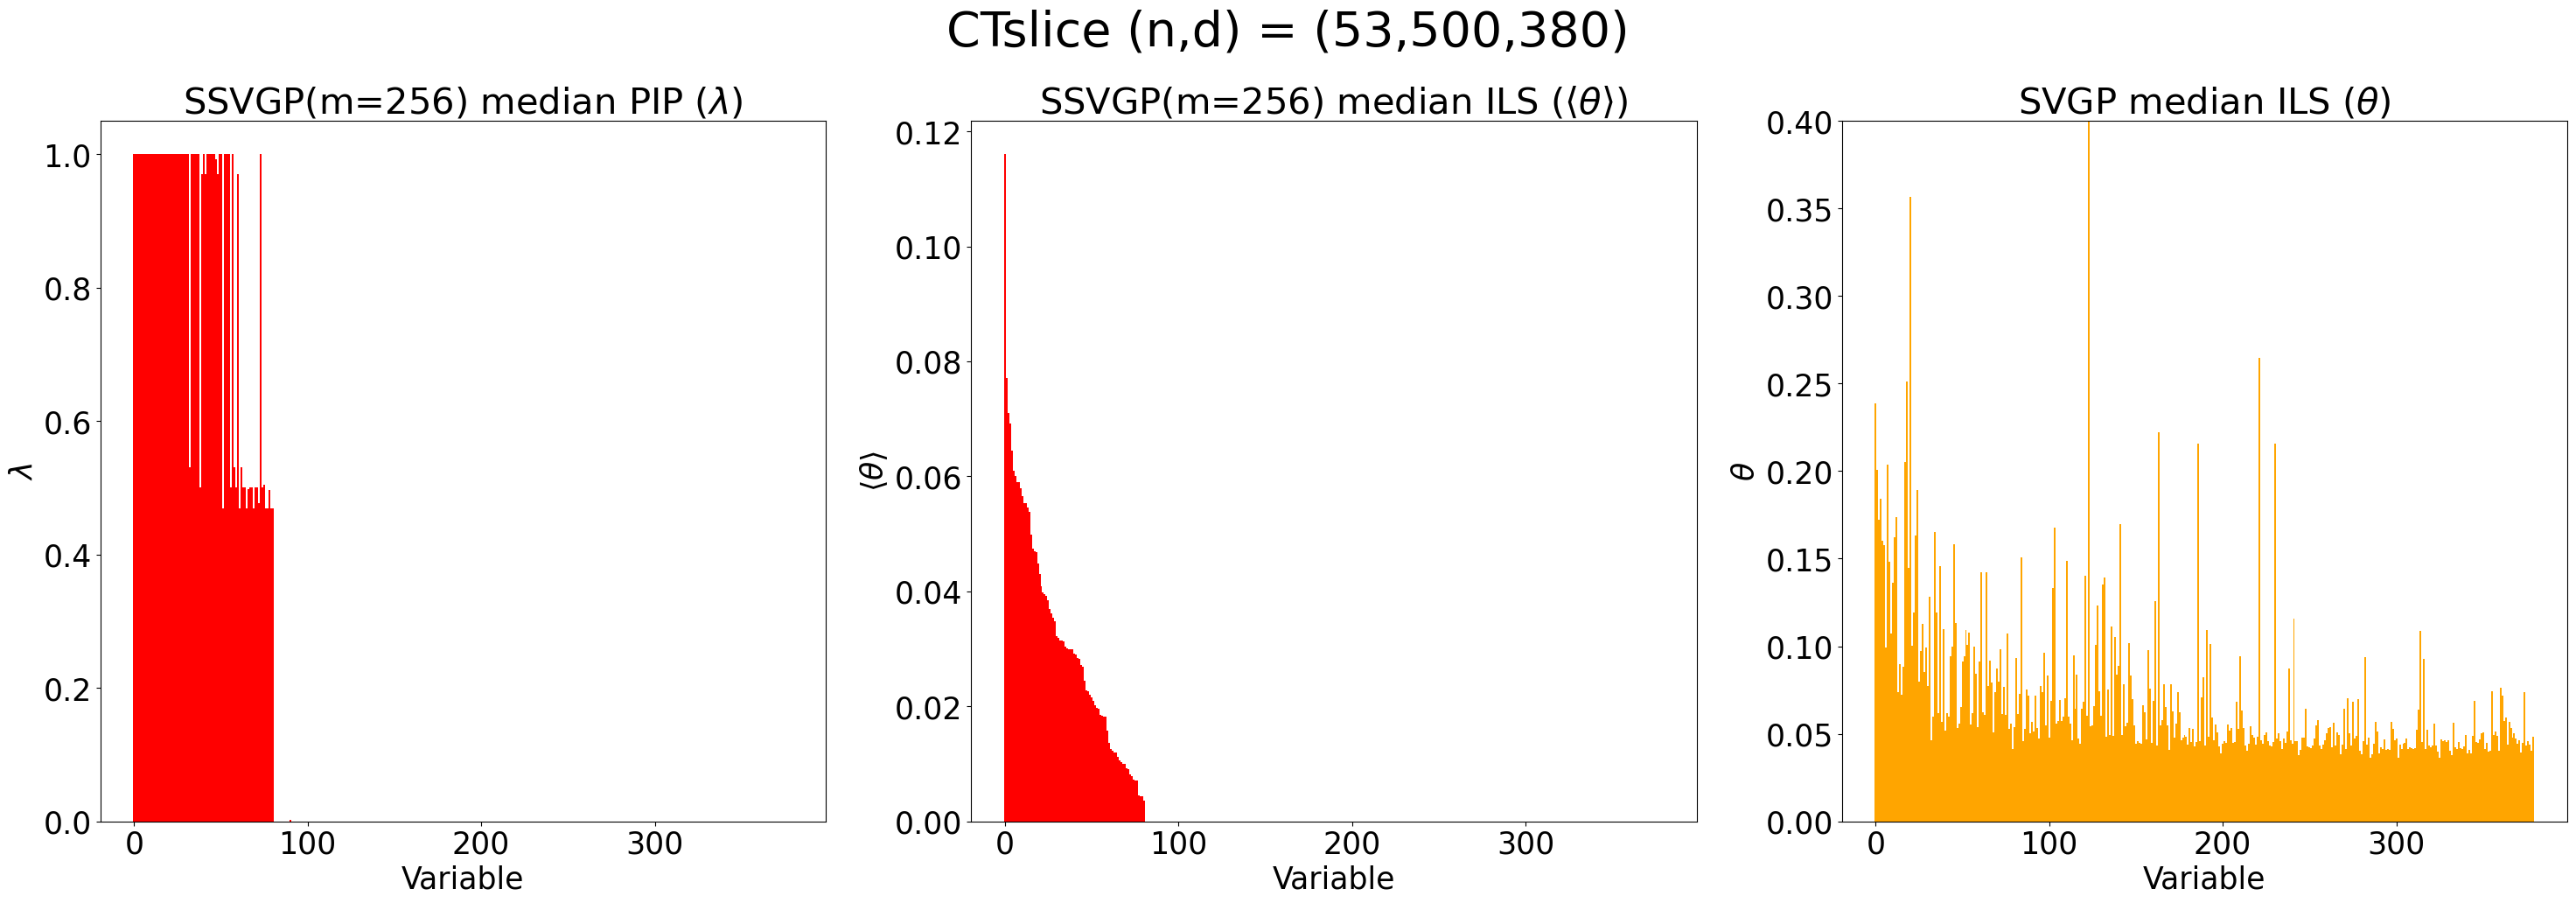

In [111]:
"""
Displaying learned PIPs
"""
runs = np.linspace(0,9,10).astype(int)
from matplotlib import rcParams, rc_file_defaults
rc_file_defaults()
plt.rc('axes',edgecolor='black')
font = {'size'   : 25}
plt.rc('font', **font)
plt.rcParams.update({'text.color' : "black",
                      'xtick.color' : "black",
                      'ytick.color' : "black",
                     'axes.labelcolor' : "black"})

w=1
order = np.argsort(np.median(np.abs(Data["L"][runs,2]),0))[::-1]

fig,axs = plt.subplots(1,3, figsize = (30,10))
fig.set_facecolor('white')
fig.suptitle("CTslice (n,d) = (53,500,380)", y=1.05, fontsize = 40)
axs[0].set_facecolor('white')
axs[1].set_facecolor('white')
axs[2].set_facecolor('white')
axs[0].bar(range(d), np.median(np.abs(Data["Lambda"][runs,2]),0)[order],width = w, color = "red")
axs[0].set_title(r"SSVGP(m=256) median PIP $(\lambda)$")
axs[0].set_xlabel("Variable")
axs[0].set_ylabel(r"$\lambda$")
axs[1].bar(range(d), np.median(np.abs(Data["L"][runs,2]),0)[order], width = w, color = "red")#, yerr = np.var(np.abs(Data["L"][:,3]),0)[order]**0.5)
axs[1].set_title(r"SSVGP(m=256) median ILS $(\langle \theta \rangle) $")
axs[1].set_xlabel("Variable")
axs[1].set_ylabel(r"$\langle \theta \rangle $")
axs[2].bar(range(d),np.median(np.abs(Data["L"][runs,1]),0)[order], width=w, color = "orange")#, yerr = np.var(np.abs(Data["L"][:,6]),0)[order]**0.5)
axs[2].set_title(r"SVGP median ILS $(\theta)$")
axs[2].set_xlabel("Variable")
axs[2].set_ylabel(r"$\theta$")
axs[2].set_ylim((0,0.4))
plt.tight_layout()
plt.show()
fig.savefig("Slice_plots",bbox_inches = 'tight')

### Getting plots

In [103]:
"""
Creating table for mean pm sd plots
"""
# Threshold and dimension choice (first element depends on best performing threshold)
nmodel = len(names)

#Column-names to fetch information from dictionary
Metrics = ["MSE", "Runtime"]

# Empty table
Table = np.zeros((nmodel, 10,3))

# Filling table
for i in range(len(Metrics)):
    Table[:,:,i] = Data[Metrics[i]].T
    Table[:,:,2] = np.sum(Data["Lambda"]>0.01,2).T
    Table[:2,:,2]= d

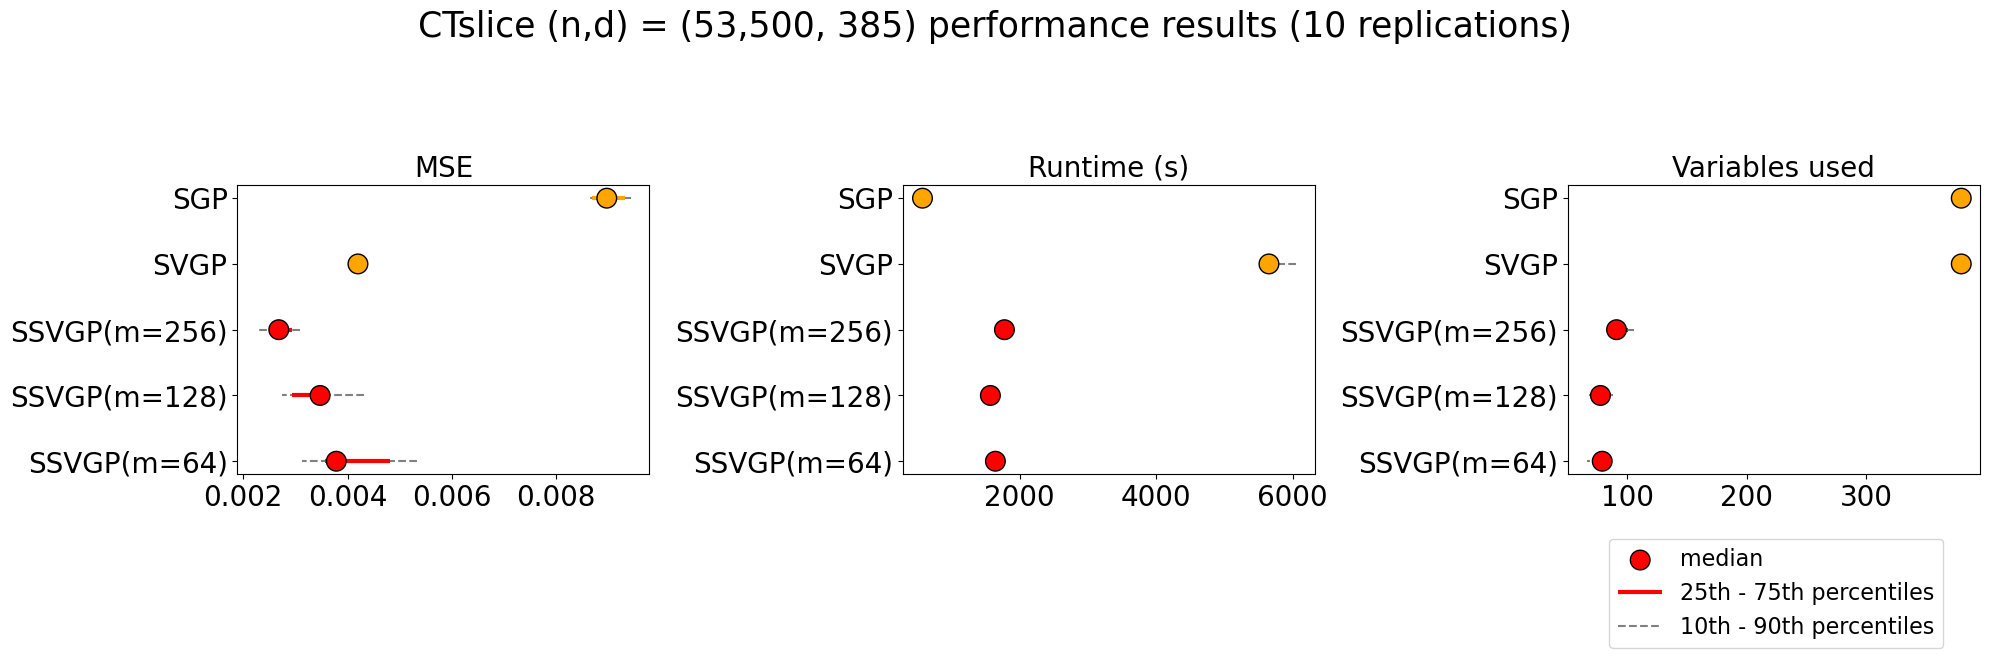

In [109]:
"""
Mean and sd plot
"""
plt.rc('axes',edgecolor='black')
font = {'family' : 'normal',
        'size'   : 32}
plt.rc('font', **font)

inds = [1,2,3,4,5]
c1 = "red"
c1b = "orange"
c2 = "grey"
c3 = "lightgrey"
colours = [np.concatenate((np.repeat(c1,3),np.repeat(c1b,2))),np.repeat(c2,5),np.repeat(c3,5)]
xlim = [(0.1,0.25), (0.5,1.01), (2,100)]
quantiles = [0.75,0.9,0.99]
linestyles = ["-", "--","--"]
lws = [3,1.5,1.5]

# Creating plots of results
from matplotlib import rcParams, rc_file_defaults
Metric_names = ["MSE", "Runtime (s)", "Variables used"]
labelsize = 20
rc_file_defaults()
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 

fig,axs = plt.subplots(nrows=1, ncols=3, figsize = (20,6.5))
fig.suptitle(r" CTslice (n,d) = (53,500, 385) performance results (10 replications) ", fontsize = 25, y = 1.2)
for i in range(np.shape(Table)[2]):
    axs[i].set_title(Metric_names[i], Fontsize = 20)
    axs[i].set_yticks(inds[::-1])
    means = np.median(Table[:,:,i],1)[::-1]
    sd = np.var(Table[:,:,i],1)[::-1]**0.5
    axs[i].set_yticklabels(names)
    axs[i].scatter(means,inds, color = np.concatenate((np.repeat("red",3),np.repeat("orange",2))), s = 200, label = "median",zorder = 12, edgecolors = "black")
    for j in range(2):
        upper = np.quantile(Table[:,:,i],quantiles[j],1)[::-1]
        lower = np.quantile(Table[:,:,i],1-quantiles[j],1)[::-1]
        axs[i].hlines(inds, upper, lower, color=colours[j], linestyle=linestyles[j], lw=lws[j], 
                      label = "{0}th - {1}th percentiles".format(int(100-quantiles[j]*100), int(quantiles[j]*100)),
                    zorder = 10-3*j)
plt.legend(fontsize=16, loc = (0.1,-0.6))
plt.tight_layout()
plt.show()
fig.savefig("CTslice_performance_plots", bbox_inches = "tight")